## <center>  MATH11146: Modern Optimization Methods for Big Data Problems </center>

<center> University of Edinburgh</center>

<center>Lecturer: Peter Richtarik</center>

<center>Tutors: Sona Galovicova, Filip Hanzely and Nicolas Loizou</center>

##  <center>Lab 5: Parallel and Accelerated Methods</center>
<center>(C) Nicolas Loizou and Peter Richtarik </center>
<center> 6.2.2017 </center>


# 1) Introduction

### The Problem
Consider the problem of solving a consistent linear system:

$$Ax = b,$$

where $A\in \mathbb{R}^{m\times n}$ and $b\in \mathbb{R}^m$. 

### Methods for solving this
Recall that the <b>basic method</b> with stepsize $\omega>0$ performs iterations of the form

$$ x_{k+1} \leftarrow x_{k} - \omega B^{-1} A^\top S_k (S_k^\top A B^{-1} A^\top S_k)^\dagger S_k^\top (Ax_k-b), $$

where 
- $B$ is a fixed $n\times n$ positive definite matrix, and
- $S_k$ is drawn in an i.i.d. fashion from a fixed distribution $\cal D$.

Recall that the method can be interpreted in several ways (e.g., stochastic gradient descent, stochastic Newton descent, stochastic fixed point method with relaxation, stochastic projection method).

### Goal of this lab
The main Goal of this lab is to experiment with implementations of the Parallel and Accelerated methods presented in the lectures. 

In this lab, the Basic, Parallel and Accelerated methods were coded up for you. Play with the code and try to see what it does. There will be some exercices at the end. 

# 2) Generate Data

We first generate an $m\times n$ matrix $A$, then a random vector $x^*$ ($\verb"x_star"$) and finally, set $b = A x^*$. This way we will know the system we have generated is consistent (i.e., that it has a solution). 

You can generate data is a smarter way of you wish, as we have done before.

In [1]:
srand(1) # set random seed to 1

m = 30
n = 10

# Generate random matrix A

A = randn(m,n) # A is a Gaussian Matrix. It has random standard normal entries. For uniform entries on [0,1], use rand() 
x_star = randn(n)
b = A*x_star

30-element Array{Float64,1}:
 -2.95577  
 -4.30752  
 -3.68793  
  1.58904  
 -2.88272  
 -1.03044  
 -6.86429  
 -5.70453  
 -5.51302  
 -1.14905  
  0.536005 
  0.222824 
 -1.02577  
  ⋮        
  1.51096  
 -1.38803  
  4.05293  
 -2.35099  
  0.0892015
  6.00183  
  0.990978 
 -7.50378  
  2.29332  
  1.77663  
  1.52364  
  5.74664  

# 3) Basic Method (with Relaxation)

In the previous lab the basic method was coded for you; it is provided here as well. Notice that in the following code we also have the relaxation parameter $\omega$.

## 3.1) The Code

In [2]:
function iterate(x, A, b, Binv, S, ω)
    
    # println(x)
    return x - ω*Binv*A'*S*pinv(S'*A*Binv*A'*S)*S'*(A*x - b) # ' is the transpose operator, it has higher priority than * 
end

function RandomLinearSolve(x, A, b, Binv, sampling, T, skip, ω)
    
    (m,n) = size(A)
    xs = zeros(n, floor(Integer, T/skip) + 1) # remember the iterates x 
    fv = zeros(floor(Integer, T/skip) + 1)    # remember the residuals ||Ax-b|| 
    
    tic()
    time = 0
    
    for t=0:T
        tic()
        x = iterate(x, A, b, Binv, sampling(), ω) # notice that the 5th argument is a function
        time = time + toq()
        if t % skip == 0
            xs[:,round(Int,t/skip)+1] = x           # remember iterate x
            fv[round(Int,t/skip)+1] = norm(A*x-b)   # remeber residual 
            println("iteration: $(t), residual: $(fv[round(Int,t/skip+1)]) ")
        end
    end
        
    println("Time = ", time)
    return xs,fv
    
end

RandomLinearSolve (generic function with 1 method)

## 3.2) Sampling Strategies

In [3]:
function sampling() # for non-uniform sampling, look into the function "sample" in the package StatsBase
    
    S = zeros(m)
    S[rand(1:m)] = 1 # rand(range) returns a random number in the given range
    return S
    
end

sampling (generic function with 1 method)

In [4]:
using StatsBase

function Kac_sampling(A) # We should be careful since this function returns coordinate and not a vector
    w = zeros(size(A)[1])
    for i=1:size(A)[1]
        w[i] = A[i,:]'*A[i,:] 
    end  
    w = w./sum(w)
    return sample(WeightVec(w))
    
end

Kac_sampling (generic function with 1 method)

In [5]:
using StatsBase # You will be asked to complete this function in Exercise 3

function CoordinateSampling(A) 
    
    return S
    
end

CoordinateSampling (generic function with 1 method)

# 3) Parallel Method

In the lecture slides a parallel version of the Basic Algorithm was presented. With big data problems it is necessary to design algorithms able to utilize modern parallel computing architectures.

In [6]:
function ParallelMethod(x, A, b, Binv, sampling, T, skip, ω, τ) 
    # Here we denote with T the number of iterations and with τ the parallelism parameter
    
    (m,n) = size(A)
    xs = zeros(n, floor(Integer, T/skip) + 1) # will remember the iterates x here
    fv = zeros(floor(Integer, T/skip) + 1)    # will remember residuals ||Ax-b|| here
    
    tic()
    time = 0
    
    for k=0:T
        tic()
        Z=zeros(n,τ)
        for i=1:τ
            Z[:,i] = iterate(x, A, b, Binv, sampling(), ω) 
        end
        x=(1/τ)*(sum(Z,2)) # Average the results. Function sum(Z,2) creates a vector in R^{n} with values being the row sum of Z
        time = time + toq()
        if k % skip == 0
            xs[:,round(Int,k/skip)+1] = x           # remember iterate x
            fv[round(Int,k/skip)+1] = norm(A*x-b)   # remember residual 
            println("iteration: $(k), residual: $(fv[round(Int,k/skip+1)]) ")
        end
    end
        
    println("Time = ", time)
    return xs,fv
    
end

ParallelMethod (generic function with 1 method)

# 4) Accelerated Method

In [7]:
function AccMethod(x, A, b, Binv, sampling, T, skip, ω, γ) 
    # ω represents the relaxation parameter and γ denotes the acceleration parameter
    
    (m,n) = size(A)
    xs = zeros(n, floor(Integer, T/skip) + 1) # will remember the iterates x here
    fv = zeros(floor(Integer, T/skip) + 1)    # will remember residuals ||Ax-b|| here
    
   
    tic()
    time = 0
    
    temp = iterate(x, A, b, Binv, sampling(), ω) #create a temporary variable to save the first value z0
    
    for k=0:T
        
        tic()
        z = iterate(x, A, b, Binv, sampling(), ω) # notice that the last argument is a function
        x = γ*z+ (1-γ)*temp
        temp = z
        time = time + toq()
        
        if k % skip == 0
            xs[:,round(Int,k/skip)+1] = x           # remember iterate x
            fv[round(Int,k/skip)+1] = norm(A*x-b)   # remember residual 
            println("iteration: $(k), residual: $(fv[round(Int,k/skip+1)]) ")
        end
    end
        
    println("Time = ", time)
    return xs,fv
    
end

AccMethod (generic function with 1 method)

# 5) Plotting

The main goal of this section is to play around with the different parameters of the Accelerated Method. Remember that for $\gamma=1$ we obtain the basic method. The linear system that we are working with in this section is the Random Gaussian linear system with $A \in R^{30\times10}$.

In [8]:
x = zeros(n)  # initial iterate

Binv = eye(n) # matrix B is one of the 2 parameters of the method
B = inv(Binv)
T = 1000       # no of iterations 
skip = round(T/50)    # we shall remember x each "skip" number of iterations
#ω=1 #relaxation parameter
τ=5 #parameter for parallelization (size of minibatch)
#γ=1 #accelerated parameter (remember that γ ∈ (0,2))

AccXs1, Accfv1= AccMethod(x, A, b, Binv, sampling, T, skip, 1.0, 1.0)
AccXs2, Accfv2= AccMethod(x, A, b, Binv, sampling, T, skip, 0.2, 1.8)
AccXs3, Accfv3= AccMethod(x, A, b, Binv, sampling, T, skip, 2.0, 0.4)
AccXs4, Accfv4= AccMethod(x, A, b, Binv, sampling, T, skip, 0.4, 1.6)
AccXs5, Accfv5= AccMethod(x, A, b, Binv, sampling, T, skip, 0.6, 1.2)
AccXs6, Accfv6= AccMethod(x, A, b, Binv, sampling, T, skip, 0.8, 1.2)
AccXs7, Accfv7= AccMethod(x, A, b, Binv, sampling, T, skip, 1.2, 1.0)
AccXs8, Accfv8= AccMethod(x, A, b, Binv, sampling, T, skip, 1.4, 0.6)
AccXs9, Accfv9= AccMethod(x, A, b, Binv, sampling, T, skip, 1.6, 0.6)

iteration: 0, residual: 19.316583466377075 
iteration: 20, residual: 9.327070448490218 
iteration: 40, residual: 2.957899544374463 
iteration: 60, residual: 0.9181219760100552 
iteration: 80, residual: 0.31595704724954377 
iteration: 100, residual: 0.1928817077725821 
iteration: 120, residual: 0.08029088961378723 
iteration: 140, residual: 0.03243758971369625 
iteration: 160, residual: 0.015626793311205183 
iteration: 180, residual: 0.005589710690905136 
iteration: 200, residual: 0.00358098753921597 
iteration: 220, residual: 0.0011998955649831738 
iteration: 240, residual: 0.0005156181516789763 
iteration: 260, residual: 0.0003618158344502393 
iteration: 280, residual: 0.00022804100408096325 
iteration: 300, residual: 0.00015941237016334095 
iteration: 320, residual: 9.182587469921766e-5 
iteration: 340, residual: 6.959699638479247e-5 
iteration: 360, residual: 3.705439635932393e-5 
iteration: 380, residual: 1.2541907960366193e-5 
iteration: 400, residual: 8.91092612986608e-6 
iterati

(
[0.0438778 -0.224382 … -0.23211 -0.23211; -0.0780505 -0.0219353 … 0.20627 0.20627; … ; 0.136399 -0.204713 … 0.27247 0.27247; 0.0873694 -0.435938 … 1.19401 1.19401],

[19.5325,10.5341,3.90451,2.18285,0.291187,0.159572,0.0817827,0.0576064,0.0178062,0.00527726  …  5.75947e-13,4.20972e-13,2.72122e-13,1.25602e-13,8.07234e-14,2.23385e-14,1.21264e-14,8.56821e-15,7.20705e-15,7.0689e-15])

# 6) Testing the Accelerated Method


## 6.1) Residual

Testing the accelerated method with various parameters. We focus on the residual $||A x_k - b||$.

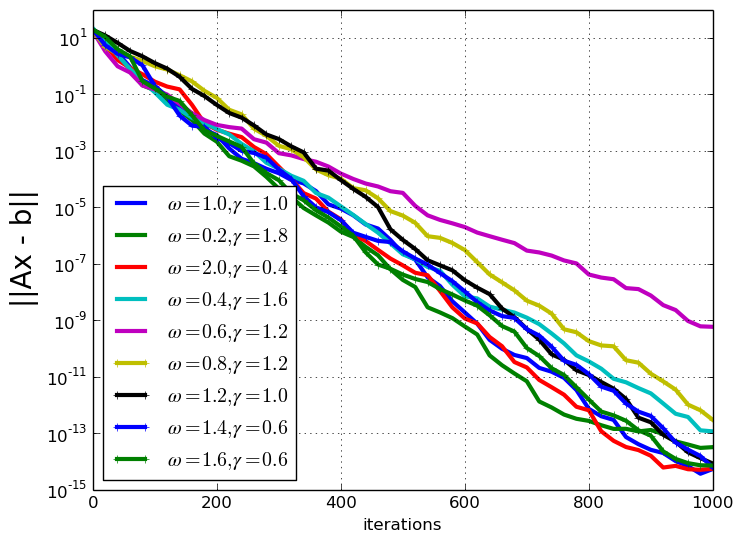

In [9]:
using PyPlot

ax = axes()
plt[:plot](skip*(0:length(Accfv1)-1), Accfv1, "-", linewidth=3.0,  label=L"ω=1.0, γ=1.0")
plt[:plot](skip*(0:length(Accfv2)-1), Accfv2, "-", linewidth=3.0,  label=L"ω=0.2, γ=1.8")
plt[:plot](skip*(0:length(Accfv3)-1), Accfv3, "-", linewidth=3.0,  label=L"ω=2.0, γ=0.4")
plt[:plot](skip*(0:length(Accfv4)-1), Accfv4, "-", linewidth=3.0,  label=L"ω=0.4, γ=1.6")
plt[:plot](skip*(0:length(Accfv5)-1), Accfv5, "-", linewidth=3.0,  label=L"ω=0.6, γ=1.2")
plt[:plot](skip*(0:length(Accfv6)-1), Accfv6, "-+", linewidth=3.0, label=L"ω=0.8, γ=1.2")
plt[:plot](skip*(0:length(Accfv7)-1), Accfv7, "-+", linewidth=3.0, label=L"ω=1.2, γ=1.0")
plt[:plot](skip*(0:length(Accfv8)-1), Accfv8, "-+", linewidth=3.0, label=L"ω=1.4, γ=0.6")
plt[:plot](skip*(0:length(Accfv9)-1), Accfv9, "-+", linewidth=3.0, label=L"ω=1.6, γ=0.6")

legend(loc="lower left")
    ylabel("||Ax - b||", fontsize=20)
    xlabel("iterations")
    ax[:set_yscale]("log")
    plt[:show]
    grid("on")

## 6.2) Standard Error

Testing the accelerated method with various parameters. We focus on the error $||x_k - x_*||_B^2$

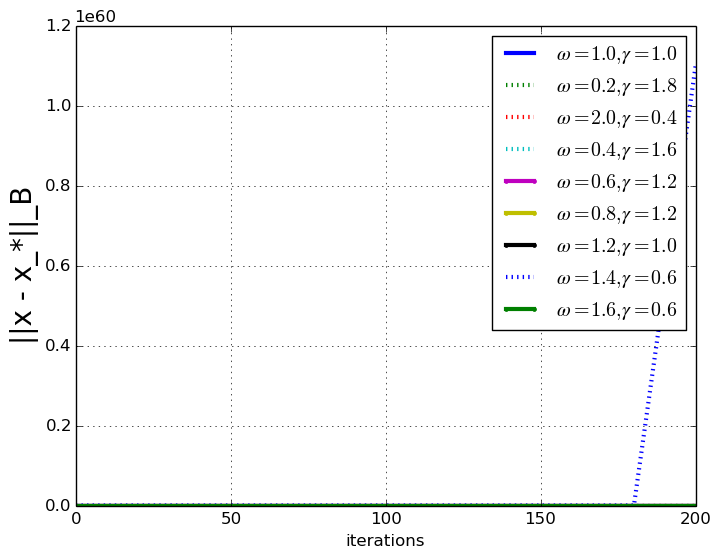

In [79]:
plt[:plot](skip*(0:length(Accfv1)-1), [sqrt((AccXs1[:,i]-x_star)'*B*(AccXs1[:,i]-x_star)) for i=1:length(Accfv1)] , "-", linewidth=3.0,  label=L"ω=1.0, γ=1.0")
plt[:plot](skip*(0:length(Accfv2)-1), [sqrt((AccXs2[:,i]-x_star)'*B*(AccXs2[:,i]-x_star)) for i=1:length(Accfv2)] , ":", linewidth=3.0,  label=L"ω=0.2, γ=1.8")
plt[:plot](skip*(0:length(Accfv3)-1), [sqrt((AccXs3[:,i]-x_star)'*B*(AccXs3[:,i]-x_star)) for i=1:length(Accfv3)] , ":", linewidth=3.0,  label=L"ω=2.0, γ=0.4")
plt[:plot](skip*(0:length(Accfv4)-1), [sqrt((AccXs4[:,i]-x_star)'*B*(AccXs4[:,i]-x_star)) for i=1:length(Accfv4)] , ":", linewidth=3.0,  label=L"ω=0.4, γ=1.6")
plt[:plot](skip*(0:length(Accfv5)-1), [sqrt((AccXs5[:,i]-x_star)'*B*(AccXs5[:,i]-x_star)) for i=1:length(Accfv5)] , ".-", linewidth=3.0, label=L"ω=0.6, γ=1.2")
plt[:plot](skip*(0:length(Accfv6)-1), [sqrt((AccXs6[:,i]-x_star)'*B*(AccXs6[:,i]-x_star)) for i=1:length(Accfv6)] , ".-", linewidth=3.0, label=L"ω=0.8, γ=1.2")
plt[:plot](skip*(0:length(Accfv7)-1), [sqrt((AccXs7[:,i]-x_star)'*B*(AccXs7[:,i]-x_star)) for i=1:length(Accfv7)] , ".-", linewidth=3.0, label=L"ω=1.2, γ=1.0")
plt[:plot](skip*(0:length(Accfv8)-1), [sqrt((AccXs8[:,i]-x_star)'*B*(AccXs8[:,i]-x_star)) for i=1:length(Accfv8)] , ":", linewidth=3.0,  label=L"ω=1.4, γ=0.6")
plt[:plot](skip*(0:length(Accfv9)-1), [sqrt((AccXs9[:,i]-x_star)'*B*(AccXs9[:,i]-x_star)) for i=1:length(Accfv9)] , ".-", linewidth=3.0, label=L"ω=1.6, γ=0.6")

legend(loc="upper right")
    ylabel("||x - x_*||_B", fontsize=20)
    xlabel("iterations")
    ax[:set_yscale]("log")
    plt[:show]
    grid("on")

### Exercise 1 (Parallel Method)

Test the parallel method for τ=1, 10, 100 and 1000. Plot the iterates and report on what you
see.

### Exercise 2 (Stochastic Dual Coordinate Ascent)

If $A$ is symmetric positive definite, then we can choose $B=A$. In this case the SDSA method and the Basic Method are identical! 

If we choose $S=e^i$ with some probability $p_i$, then SDSA is also known as stochastic dual coordinate ascent (SDCA).
In particular, pick $p_i=A_{ii}/Tr(A)$.

- Code up the function "CoordinateSampling(A)" which will have as input the matrix $A$ and as output  unit coordinate vector $S$ which is chosen with probability $p_i=A_{ii}/Tr(A)$.

- It can be shown that $$W=\frac{A}{Trace(A)}$$ 

Derive this on your own. 

- By constructing $A$ so that $Trace(A)=1$, we then have that the values $\lambda_{max}$ and $\lambda_{min}^+$  are precisely the largest and smallest nonzero eigenvalues of $A$, respectively.  

Example: The following $5 \times 5$ matrix is symmetric and positive definite, with unit trace.

In [11]:
A = [0.0314   -0.0374    0.0080    0.0495   -0.1343
   -0.0374    0.0809   -0.0204   -0.0794    0.2172
    0.0080   -0.0204    0.0204    0.0269   -0.0737
    0.0495   -0.0794    0.0269    0.1259   -0.2873
   -0.1343    0.2172   -0.0737   -0.2873    0.7412]

5×5 Array{Float64,2}:
  0.0314  -0.0374   0.008    0.0495  -0.1343
 -0.0374   0.0809  -0.0204  -0.0794   0.2172
  0.008   -0.0204   0.0204   0.0269  -0.0737
  0.0495  -0.0794   0.0269   0.1259  -0.2873
 -0.1343   0.2172  -0.0737  -0.2873   0.7412

Notice that the eigenvalues of matrix $A$ are $$(\lambda_1,..,\lambda_5)=(0.0020, 0.0114, 0.0162, 0.0209, 0.9495),$$ which means that the condition number  $$\zeta =\frac{\lambda_{max}}{\lambda_{min}^+}$$  is large.

- Now code up the accelerated method with $A$ as above. Test it with several values for $\gamma$ and $\omega$, and compare the results.

### Exercise 3 (Randomized Kaczmarz Method)

From theory we know that the optimal values for parameters $\omega$ and $\gamma$ (values that give us the best theoretical convergence rate) depend on the minimum nonzero ($\lambda_{min}^+$) and the maximum eigenvalue ($\lambda_{max})$ of matrix $W=B^{-1/2}E[Z] B^{-1/2}$. Write a function that finds the minimum nonzero eigenvalue and the maximum eigenvalue of this matrix in the case of Randomized Kaczmarz Method.

Now run the algorithms using the suggested parameters from the lecture slides to solve the random Gaussian linear system. Do you stil have convergence? 

###  Exercise 4 (A More Efficient Basic Method)

There is a small problem on the available code of the function "iterate". More specifically in this function the update rule of our algorithm is executed:

 $$ x - ω*Binv*A'*S*pinv(S'*A*Binv*A'*S)*S'*(A*x - b)$$

This rule in terms of coding is a bit inefficient. 
We should not calculate the pseudoinverse, but instead solve a (small) linear system.

Can you provide the necessary code in order to make the function "iterate" as efficient as possible?

Remark: Note that the pseudoinverse operation is highly unstable (it is discontinuous). When $S'*A*A'*S$ has an eigenvalue slightly below machine precision, then the pseudoinverse will have a 0 eigenvalue in it's place. But when $S'*A*A'*S$ has an eigenvalue slightly above machine precision, the pseudoinverse will have a eigenvalue that is almost infinite in its place! 

### (*) Exercise 5 (Randomized Gossip Algorithms)

Folowing the first assignment (solving the Average Consensus Problem), design a linear system $Ax=b$  representing a simple Cycle graph (circle) with $100$ nodes. What must be the matrix $A$? What about vector $b$? Do they have specific structure?

In the literature on Randomized Gossip Algorithms it is known that one of the best ways to model a wireless sensor network is via a random geometric graph. In this model, denoted $G(n,r)$, the $n$ sensor locations are chosen uniformly and independently in the unit square, and each pair of nodes is connected if their Euclidean distance is smaller than some transmission radius $r>0$. 

Assume that in order to ensure connectivity  and minimize interference, the transmission radius is set to $r(n)=\sqrt{c log(n) / n}$, where $c>0$ is a parameter. 

Create a function that returns the incidence matrix $A$ of this graph. What is the linear system that needs to be solved?

In order to solve the Average Consensus Problem for both of these networks you can simply run one of the methods for solving linear systems. Try to understand how the parallel and accelerated method work in the gossip framework.

## 7) Extra Experiments

In [64]:
srand(1) # set random seed to 1

A =[    0.2702         0    0.0002   -0.0002    0.1085    0.0009         0    0.1443         0    0.1641
         0    0.0200         0         0         0         0         0         0         0         0
    0.0002         0    0.0345    0.0040   -0.0000    0.0045   -0.0012   -0.0001         0   -0.0001
   -0.0002         0    0.0040    0.0373    0.0000   -0.0032   -0.0017    0.0001         0    0.0001
    0.1085         0   -0.0000    0.0000    0.0636   -0.0001         0    0.0785         0    0.0893
    0.0009         0    0.0045   -0.0032   -0.0001    0.0485         0   -0.0005         0   -0.0006
         0         0   -0.0012   -0.0017         0         0    0.0699         0         0         0
    0.1443         0   -0.0001    0.0001    0.0785   -0.0005         0    0.1699         0    0.1022
         0         0         0         0         0         0         0         0    0.0900         0
    0.1641         0   -0.0001    0.0001    0.0893   -0.0006         0    0.1022         0    0.1961]



(m,n) = size(A)
x_star = randn(n)
b = A*x_star

10-element Array{Float64,1}:
 -0.266889  
  0.00764792
 -0.0217713 
 -0.00792038
 -0.160578  
  0.0136591 
  0.161162  
 -0.364148  
  0.0476969 
 -0.173363  

In [65]:
trace(A)

1.0

In [66]:
using StatsBase
function CoordinateSampling(A) 
    # remember that in the case of coordinate descent the convinient probabilities are p_i=A_{ii}/Tr(A)
    
    w=zeros(size(A)[1])
    for i=1:size(A)[1]
        w[i]= A[i,i]
    end  
    w=w./trace(A)
    return sample(WeightVec(w))
    
end

CoordinateSampling (generic function with 1 method)

In [67]:
function AccCoordinate(x, A, b, Binv, T, skip, ω, γ) 
    # ω represents the relaxation parameter and γ denotes the acceleration parameter
    
    (m,n) = size(A)
    xs = zeros(n, floor(Integer, T/skip) + 1) # will remember the iterates x here
    fv = zeros(floor(Integer, T/skip) + 1)    # will remember residuals ||Ax-b|| here
    I = eye(m)
   
    tic()
    time = 0
    
    S = I[:,CoordinateSampling(A)]
    temp = iterate(x, A, b, Binv, S, ω) #create a temporary variable to save the first value z0
    
    for k=0:T
         if k % skip == 0
            xs[:,round(Int,k/skip)+1] = x           # remember iterate x
            fv[round(Int,k/skip)+1] = norm(A*x-b)   # remember residual 
            println("iteration: $(k), residual: $(fv[round(Int,k/skip+1)]) ")
        end
        
        tic()
        S=I[:,CoordinateSampling(A)]
        z = iterate(x, A, b, Binv, S, ω) # notice that the last argument is a function
        x = γ*z+ (1-γ)*temp
        temp = z
        time = time + toq()
        
       
    end
        
    println("Time = ", time)
    return xs,fv
    
end

AccCoordinate (generic function with 1 method)

## 7.1) Fix $\omega=1$ ad test a selection of $\gamma\in (1,2)$

In [68]:
x = zeros(n)  # initial iterate
B = A
Binv = inv(B) # matrix B is one of the 2 parameters of the method

T = 50*n      # no of iterations 
skip = round(T/10)    # we shall remember x each "skip" number of iterations

AccXs1, Accfv1= AccCoordinate(x, A, b, Binv, T, skip, 1, 1.0)
AccXs4, Accfv4= AccCoordinate(x, A, b, Binv, T, skip, 1, 1.2)
AccXs5, Accfv5= AccCoordinate(x, A, b, Binv, T, skip, 1, 1.4)
AccXs6, Accfv6= AccCoordinate(x, A, b, Binv, T, skip, 1, 1.6)
AccXs7, Accfv7= AccCoordinate(x, A, b, Binv, T, skip, 1, 1.8)


iteration: 0, residual: 0.5373113104726451 
iteration: 50, residual: 0.008151103574244194 
iteration: 100, residual: 0.004308920670064852 
iteration: 150, residual: 0.0033743864964505895 
iteration: 200, residual: 0.0027218551142665385 
iteration: 250, residual: 0.002567754863052388 
iteration: 300, residual: 0.0003361606552612443 
iteration: 350, residual: 0.0005755754097780937 
iteration: 400, residual: 9.424035172731468e-5 
iteration: 450, residual: 7.132836447166578e-5 
iteration: 500, residual: 3.8679462612252034e-5 
Time = 0.013572268999999991
iteration: 0, residual: 0.5373113104726451 
iteration: 50, residual: 0.015157252688898554 
iteration: 100, residual: 0.002360305513993457 
iteration: 150, residual: 0.0008780640771961185 
iteration: 200, residual: 0.0006437464181870846 
iteration: 250, residual: 0.0002107441628567693 
iteration: 300, residual: 0.00010709634190688164 
iteration: 350, residual: 3.0849617812127184e-5 
iteration: 400, residual: 1.0716005636407552e-5 
iteration:

(
[0.0 8.81372 … -1.42886e8 -1.63884e8; 0.0 0.0 … 22.7535 24.8557; … ; 0.0 0.529966 … 0.529966 0.529966; 0.0 -24.9468 … -2.16102e8 5.10017e7],

[0.537311,2.76098,20.8545,1583.63,1459.24,41167.3,3.28263e5,1.3148e6,8.25437e7,3.61169e8,1.59702e9])

## 7.2) Residual

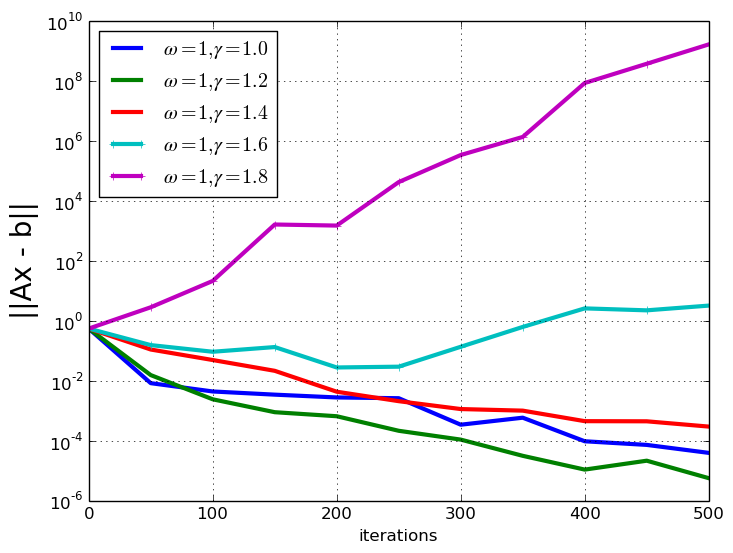

In [69]:
using PyPlot

ax = axes()
plt[:plot](skip*(0:length(Accfv1)-1), Accfv1, "-", linewidth=3.0,  label=L"ω=1, γ=1.0")
plt[:plot](skip*(0:length(Accfv4)-1), Accfv4, "-", linewidth=3.0,  label=L"ω=1, γ=1.2")
plt[:plot](skip*(0:length(Accfv5)-1), Accfv5, "-", linewidth=3.0,  label=L"ω=1, γ=1.4")
plt[:plot](skip*(0:length(Accfv6)-1), Accfv6, "-+", linewidth=3.0, label=L"ω=1, γ=1.6")
plt[:plot](skip*(0:length(Accfv7)-1), Accfv7, "-+", linewidth=3.0, label=L"ω=1, γ=1.8")

legend(loc="upper left")
    ylabel("||Ax - b||", fontsize=20)
    xlabel("iterations")
    ax[:set_yscale]("log")
    plt[:show]
    grid("on")

## 7.3) Standard Error

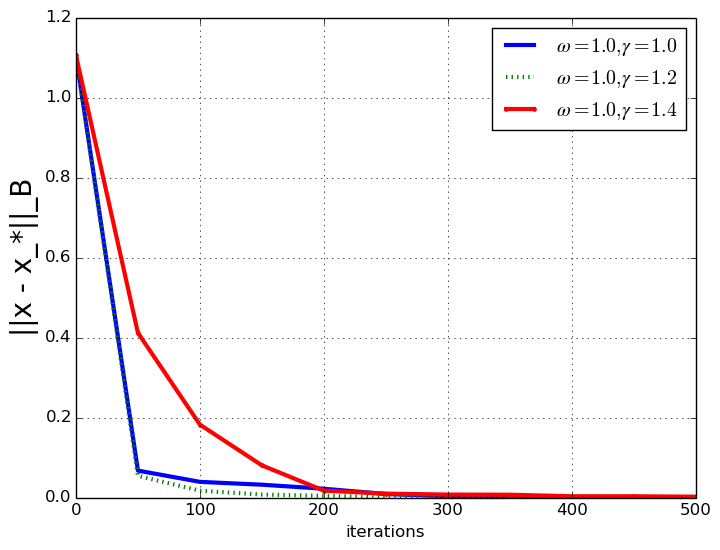

In [70]:
plt[:plot](skip*(0:length(Accfv1)-1), [sqrt((AccXs1[:,i]-x_star)'*B*(AccXs1[:,i]-x_star)) for i=1:length(Accfv1)] , "-", linewidth=3.0,  label=L"ω=1.0, γ=1.0")
plt[:plot](skip*(0:length(Accfv4)-1), [sqrt((AccXs4[:,i]-x_star)'*B*(AccXs4[:,i]-x_star)) for i=1:length(Accfv4)] , ":", linewidth=3.0,  label=L"ω=1.0, γ=1.2")
plt[:plot](skip*(0:length(Accfv5)-1), [sqrt((AccXs5[:,i]-x_star)'*B*(AccXs5[:,i]-x_star)) for i=1:length(Accfv5)] , ".-", linewidth=3.0, label=L"ω=1.0, γ=1.4")
#plt[:plot](skip*(0:length(Accfv7)-1), [sqrt((AccXs7[:,i]-x_star)'*B*(AccXs7[:,i]-x_star)) for i=1:length(Accfv7)] , ".-", linewidth=3.0, label=L"ω=1, γ=1.8")
#plt[:plot](skip*(0:length(Accfv8)-1), [sqrt((AccXs8[:,i]-x_star)'*B*(AccXs8[:,i]-x_star)) for i=1:length(Accfv8)] , ":", linewidth=3.0,  label=L"ω=1, γ=1.9")
#plt[:plot](skip*(0:length(Accfv9)-1), [sqrt((AccXs9[:,i]-x_star)'*B*(AccXs9[:,i]-x_star)) for i=1:length(Accfv9)] , ".-", linewidth=3.0, label=L"ω=1, γ=1.95")

legend(loc="upper right")
    ylabel("||x - x_*||_B", fontsize=20)
    xlabel("iterations")
    ax[:set_yscale]("log")
    plt[:show]
    grid("on")

## 7.4) Function Values: 

$$f(x)= \frac{1}{2}(x-x_*)^\top E[Z] (x-x_*) = \frac{1}{2 trace(A)}(x-x_*)^\top A^\top A(x-x_*)$$

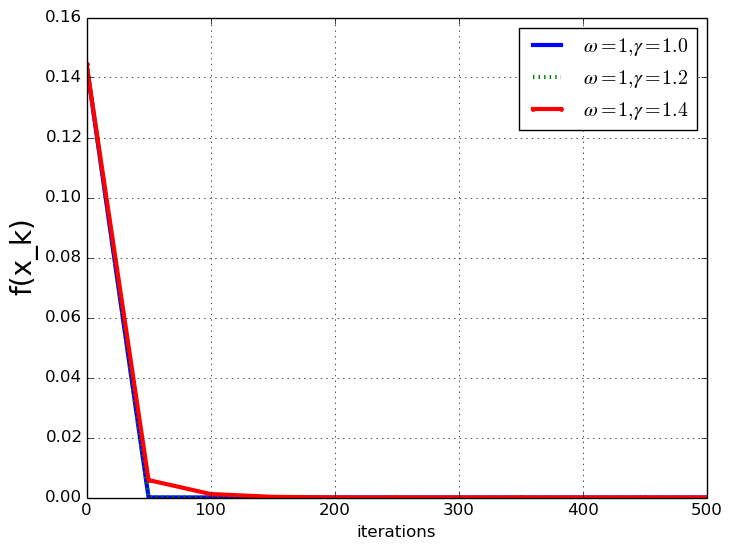

In [71]:
plt[:plot](skip*(0:length(Accfv1)-1),  [(1/2)*(1/trace(A))*(AccXs1[:,i]-x_star)'*A'*A*(AccXs1[:,i]-x_star) for i=1:length(Accfv1)] , "-", linewidth=3.0,  label=L"ω=1, γ=1.0")
plt[:plot](skip*(0:length(Accfv4)-1),  [(1/2)*(1/trace(A))*(AccXs4[:,i]-x_star)'*A'*A*(AccXs4[:,i]-x_star) for i=1:length(Accfv1)] , ":", linewidth=3.0,  label=L"ω=1, γ=1.2")
plt[:plot](skip*(0:length(Accfv5)-1),  [(1/2)*(1/trace(A))*(AccXs5[:,i]-x_star)'*A'*A*(AccXs5[:,i]-x_star) for i=1:length(Accfv1)], ".-", linewidth=3.0, label=L"ω=1, γ=1.4")

legend(loc="upper right")
ylabel("f(x_k)", fontsize=20)
    xlabel("iterations")
    ax[:set_yscale]("log")
    plt[:show]
    grid("on")

## 7.5) Assorted combination of $\omega \in (0,2)$ and $\gamma \in (1,2)$

In [72]:
x = zeros(n)  # initial iterate
B = A
Binv = inv(B) # matrix B is one of the 2 parameters of the method

T = 200      # no of iterations 
skip = round(T/10) 

Xs1, fv1= AccCoordinate(x, A, b, Binv, T,skip,1,1)
Xs2, fv2= AccCoordinate(x, A, b, Binv, T,skip,0.9,1.2)
Xs3, fv3= AccCoordinate(x, A, b, Binv, T,skip,0.2,1.4)
Xs4, fv4= AccCoordinate(x, A, b, Binv, T,skip,0.4,1)
Xs5, fv5= AccCoordinate(x, A, b, Binv, T,skip,0.6,1.2)
Xs6, fv6= AccCoordinate(x, A, b, Binv, T,skip,0.8,1.2)
Xs7, fv7= AccCoordinate(x, A, b, Binv, T,skip,1.2,1)
Xs8, fv8= AccCoordinate(x, A, b, Binv, T,skip,1.1,1.3)
Xs9, fv9= AccCoordinate(x, A, b, Binv, T,skip,0.2,1.1)

iteration: 0, residual: 0.5373113104726451 
iteration: 20, residual: 0.16478233825283276 
iteration: 40, residual: 0.16069419218934608 
iteration: 60, residual: 0.01176624120610874 
iteration: 80, residual: 0.007328021826694525 
iteration: 100, residual: 0.003684310217778536 
iteration: 120, residual: 0.0033001893283809204 
iteration: 140, residual: 0.0023892700336773155 
iteration: 160, residual: 0.0019303098851712807 
iteration: 180, residual: 0.0015330636597023612 
iteration: 200, residual: 0.0028556426343432856 
Time = 0.006737359000000004
iteration: 0, residual: 0.5373113104726451 
iteration: 20, residual: 0.06039501751784785 
iteration: 40, residual: 0.01172191448091667 
iteration: 60, residual: 0.007828119112857888 
iteration: 80, residual: 0.007256961248282585 
iteration: 100, residual: 0.005079226998958116 
iteration: 120, residual: 0.0028260846854707097 
iteration: 140, residual: 0.0028347954334552246 
iteration: 160, residual: 0.004736039914576476 
iteration: 180, residual: 

(
[0.0 -0.259892 … 0.147453 0.170122; 0.0 0.0849768 … 0.201962 0.242458; … ; 0.0 0.209631 … 0.504036 0.517766; 0.0 -0.336865 … 0.326154 0.336828],

[0.537311,0.184536,0.155111,0.0992283,0.0582786,0.0390601,0.0278202,0.0213885,0.01426,0.0117266,0.00948893])

### Residual

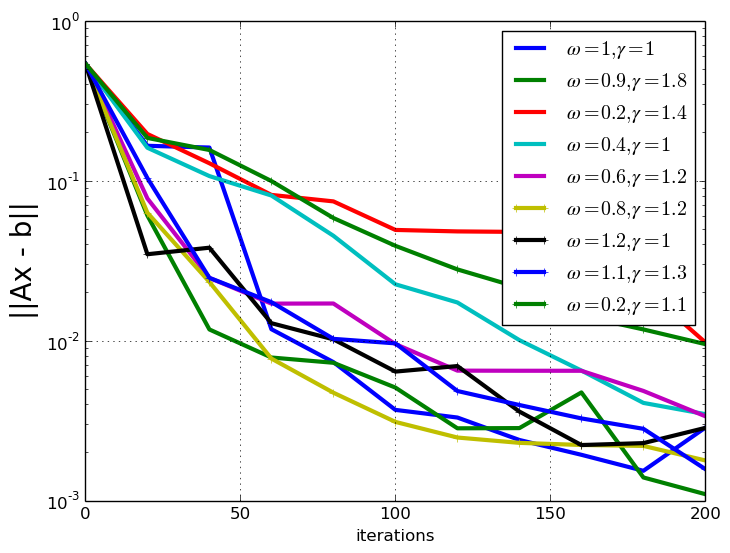

In [73]:
using PyPlot

ax = axes()
plt[:plot](skip*(0:length(fv1)-1), fv1, "-", linewidth=3.0,  label=L"ω=1, γ=1")
plt[:plot](skip*(0:length(fv2)-1), fv2, "-", linewidth=3.0,  label=L"ω=0.9, γ=1.8")
plt[:plot](skip*(0:length(fv3)-1), fv3, "-", linewidth=3.0,  label=L"ω=0.2, γ=1.4")
plt[:plot](skip*(0:length(fv4)-1), fv4, "-", linewidth=3.0,  label=L"ω=0.4, γ=1")
plt[:plot](skip*(0:length(fv5)-1), fv5, "-", linewidth=3.0,  label=L"ω=0.6, γ=1.2")
plt[:plot](skip*(0:length(fv6)-1), fv6, "-+", linewidth=3.0, label=L"ω=0.8, γ=1.2")
plt[:plot](skip*(0:length(fv7)-1), fv7, "-+", linewidth=3.0, label=L"ω=1.2, γ=1")
plt[:plot](skip*(0:length(fv8)-1), fv8, "-+", linewidth=3.0, label=L"ω=1.1, γ=1.3")
plt[:plot](skip*(0:length(fv9)-1), fv9, "-+", linewidth=3.0, label=L"ω=0.2, γ=1.1")

legend(loc="upper right")
    ylabel("||Ax - b||", fontsize=20)
    xlabel("iterations")
    ax[:set_yscale]("log")
    plt[:show]
    grid("on")

### Standard Error

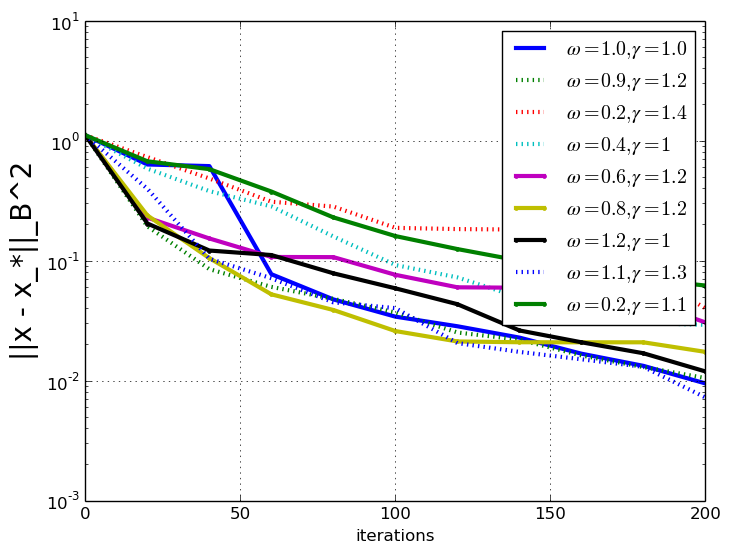

In [76]:
using PyPlot

ax = axes()
plt[:plot](skip*(0:length(fv1)-1), [sqrt((Xs1[:,i]-x_star)'*B*(Xs1[:,i]-x_star)) for i=1:length(fv1)] , "-", linewidth=3.0,  label=L"ω=1.0, γ=1.0")
plt[:plot](skip*(0:length(fv2)-1), [sqrt((Xs2[:,i]-x_star)'*B*(Xs2[:,i]-x_star)) for i=1:length(fv2)] , ":", linewidth=3.0,  label=L"ω=0.9, γ=1.2")
plt[:plot](skip*(0:length(fv3)-1), [sqrt((Xs3[:,i]-x_star)'*B*(Xs3[:,i]-x_star)) for i=1:length(fv3)] , ":", linewidth=3.0,  label=L"ω=0.2, γ=1.4")
plt[:plot](skip*(0:length(fv4)-1), [sqrt((Xs4[:,i]-x_star)'*B*(Xs4[:,i]-x_star)) for i=1:length(fv4)] , ":", linewidth=3.0,  label=L"ω=0.4, γ=1")
plt[:plot](skip*(0:length(fv5)-1), [sqrt((Xs5[:,i]-x_star)'*B*(Xs5[:,i]-x_star)) for i=1:length(fv5)] , ".-", linewidth=3.0, label=L"ω=0.6, γ=1.2")
plt[:plot](skip*(0:length(fv6)-1), [sqrt((Xs6[:,i]-x_star)'*B*(Xs6[:,i]-x_star)) for i=1:length(fv6)] , ".-", linewidth=3.0, label=L"ω=0.8, γ=1.2")
plt[:plot](skip*(0:length(fv7)-1), [sqrt((Xs7[:,i]-x_star)'*B*(Xs7[:,i]-x_star)) for i=1:length(fv7)] , ".-", linewidth=3.0, label=L"ω=1.2, γ=1")
plt[:plot](skip*(0:length(fv8)-1), [sqrt((Xs8[:,i]-x_star)'*B*(Xs8[:,i]-x_star)) for i=1:length(fv8)] , ":", linewidth=3.0,  label=L"ω=1.1, γ=1.3")
plt[:plot](skip*(0:length(fv9)-1), [sqrt((Xs9[:,i]-x_star)'*B*(Xs9[:,i]-x_star)) for i=1:length(fv9)] , ".-", linewidth=3.0, label=L"ω=0.2, γ=1.1")

legend(loc="upper right")
    ylabel("||x - x_*||_B^2", fontsize=20)
    xlabel("iterations")
    ax[:set_yscale]("log")
    plt[:show]
    grid("on")

### Function Values

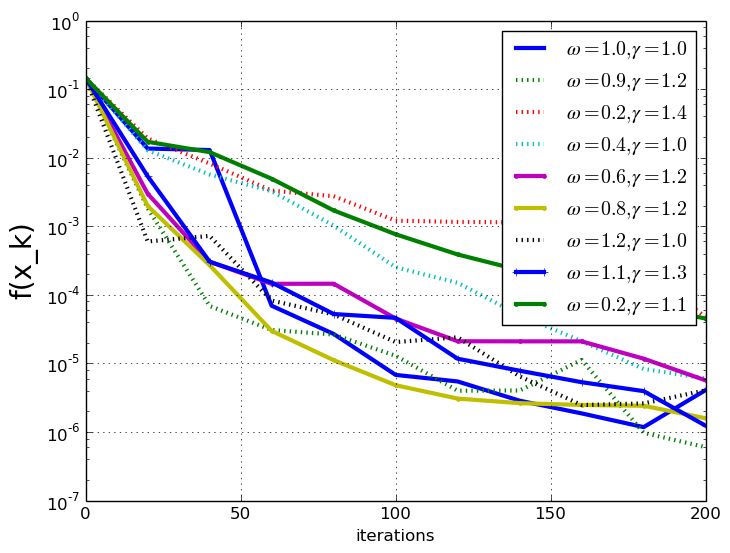

In [77]:
using PyPlot

ax = axes()
plt[:plot](skip*(0:length(fv1)-1),  [(1/2)*(1/trace(A))*(Xs1[:,i]-x_star)'*A'*A*(Xs1[:,i]-x_star) for i=1:length(fv1)] , "-", linewidth=3.0,  label=L"ω=1.0, γ=1.0")
plt[:plot](skip*(0:length(fv2)-1),  [(1/2)*(1/trace(A))*(Xs2[:,i]-x_star)'*A'*A*(Xs2[:,i]-x_star) for i=1:length(fv1)] , ":", linewidth=3.0,  label=L"ω=0.9, γ=1.2")
plt[:plot](skip*(0:length(fv3)-1),  [(1/2)*(1/trace(A))*(Xs3[:,i]-x_star)'*A'*A*(Xs3[:,i]-x_star) for i=1:length(fv1)] , ":", linewidth=3.0,  label=L"ω=0.2, γ=1.4")
plt[:plot](skip*(0:length(fv4)-1),  [(1/2)*(1/trace(A))*(Xs4[:,i]-x_star)'*A'*A*(Xs4[:,i]-x_star) for i=1:length(fv1)] , ":", linewidth=3.0,  label=L"ω=0.4, γ=1.0")
plt[:plot](skip*(0:length(fv5)-1),  [(1/2)*(1/trace(A))*(Xs5[:,i]-x_star)'*A'*A*(Xs5[:,i]-x_star) for i=1:length(fv1)], ".-", linewidth=3.0, label=L"ω=0.6, γ=1.2")
plt[:plot](skip*(0:length(fv6)-1),  [(1/2)*(1/trace(A))*(Xs6[:,i]-x_star)'*A'*A*(Xs6[:,i]-x_star) for i=1:length(fv1)] , ".-", linewidth=3.0, label=L"ω=0.8, γ=1.2")
plt[:plot](skip*(0:length(fv7)-1),  [(1/2)*(1/trace(A))*(Xs7[:,i]-x_star)'*A'*A*(Xs7[:,i]-x_star) for i=1:length(fv1)] , ":", linewidth=3.0,  label=L"ω=1.2, γ=1.0")
plt[:plot](skip*(0:length(fv8)-1),  [(1/2)*(1/trace(A))*(Xs8[:,i]-x_star)'*A'*A*(Xs8[:,i]-x_star) for i=1:length(fv1)], "+-", linewidth=3.0, label=L"ω=1.1, γ=1.3")
plt[:plot](skip*(0:length(fv9)-1),  [(1/2)*(1/trace(A))*(Xs9[:,i]-x_star)'*A'*A*(Xs9[:,i]-x_star) for i=1:length(fv1)] , ".-", linewidth=3.0, label=L"ω=0.2, γ=1.1")

legend(loc="upper right")
ylabel("f(x_k)", fontsize=20)
    xlabel("iterations")
    ax[:set_yscale]("log")
    plt[:show]
    grid("on")